In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 15.8 MB/s 
     |████████████████████████████████| 3.5 MB 15.1 MB/s 


**Data set loading**

▶ Cora dataset consists of 2708 scientific publications that are classified into 7 clasess and each publication is represented by a 0-1 word vector showing the correspoding word belongs to the publication or not. The features are the unique words of the whole dataset gathered using the bag of words;
1433 unique words.



> Nodes = Publications (Papers, Books ...)

> Edges = Citations

> Node Features = word vectors

7 Labels = Pubilcation classes e.g. Neural_Networks, Reinforcement_Learning, ...


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
#library to normalize the features features here are selected using the bag of words 

In [ ]:
dataset = Planetoid(root="data/Planetoid", name='Cora', transform=NormalizeFeatures())

Processing...
Done!


### ▶**Question1**

In [ ]:
def dloader(dataset): 
  print(f'Cora dataset: {dataset}:')
  print('***************************************')
  print(f'Number of graphs: {len(dataset)}')
  print(f'Number of features: {dataset.num_features}')
  print(f'Number of classes: {dataset.num_classes}')

  data = dataset[0] 
  print(f'Number of nodes: {data.num_nodes}')
  print(f'Number of edges: {data.num_edges}')
  print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
  print(f'Number of training nodes: {data.train_mask.sum()}')
  print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
  print(f'Has isolated nodes: {data.has_isolated_nodes()}')
  print(f'Has self-loops: {data.has_self_loops()}')
  print(f'Is undirected: {data.is_undirected()}')
  return

dloader(dataset)


Cora dataset: Cora():
***************************************
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## ▶**Questions 2,3,4,6**

**print number of nodes x features**

In [ ]:
data = dataset[0] 
print(data.x.shape)
print("The node labels :",data.y)

torch.Size([2708, 1433])
The node labels : tensor([3, 4, 4,  ..., 3, 3, 3])


### **Building the Model with 2 convolution layers**

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv 

class GCN2(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN2, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)


    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)


        # Output layer 
        x = F.log_softmax(x)
        return x

model2 = GCN2(hidden_channels=16)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)
print(model2)

GCN2(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [ ]:
print(len(data.test_mask) == data.num_nodes)
data.test_mask

True


tensor([False, False, False,  ...,  True,  True,  True])

### **Train an Test implemetation**

In [ ]:
 
def Train():
    model2.train()
    optimizer.zero_grad()  # Reset gradients.
    # Perform a single forward pass.
    predicted_y = model2(data.x, data.edge_index)
    true_y = data.y
    # train loss
    loss = F.nll_loss(predicted_y[data.train_mask], true_y[data.train_mask])
    # validiation loss
    loss_validation = F.nll_loss(predicted_y[data.val_mask], true_y[data.val_mask])
    # train accuracy
    pred = predicted_y.argmax(dim=1)
    correct = pred[data.train_mask] == data.y[data.train_mask] 
    train_acc = int(correct.sum()) / int(data.train_mask.sum())  

    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters such that minimize the loss.
    return loss , loss_validation, train_acc
    
def Test(mask):
    model2.eval()
    out = model2(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
    acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
    return acc
 

min_val_loss = 1.9452
for epoch in range(101):
    loss, loss_for_val, train_acc = Train()
    val_acc = Test(data.val_mask)
    test_acc = Test(data.test_mask)
    if (loss_for_val < min_val_loss):
        min_val_loss = loss_for_val
    
    print( F'Epoch:{epoch}, Train_loss:{loss} ,Val_Loss:{loss_for_val:.4f}, Val_acc: {val_acc:.4f}, Train_acc:{train_acc:.4f} ,Test_acc: {test_acc:.4f}')
print('minimum_loss_validation: ', min_val_loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:0, Train_loss:1.9456863403320312 ,Val_Loss:1.9452, Val_acc: 0.1080, Train_acc:0.1500 ,Test_acc: 0.1380
Epoch:1, Train_loss:1.9413901567459106 ,Val_Loss:1.9461, Val_acc: 0.1260, Train_acc:0.2357 ,Test_acc: 0.1610
Epoch:2, Train_loss:1.934025764465332 ,Val_Loss:1.9403, Val_acc: 0.3940, Train_acc:0.4000 ,Test_acc: 0.4070
Epoch:3, Train_loss:1.9248288869857788 ,Val_Loss:1.9322, Val_acc: 0.2080, Train_acc:0.4429 ,Test_acc: 0.2370
Epoch:4, Train_loss:1.9121124744415283 ,Val_Loss:1.9258, Val_acc: 0.1560, Train_acc:0.3857 ,Test_acc: 0.1890
Epoch:5, Train_loss:1.9059110879898071 ,Val_Loss:1.9190, Val_acc: 0.1500, Train_acc:0.3071 ,Test_acc: 0.1750
Epoch:6, Train_loss:1.8948856592178345 ,Val_Loss:1.9136, Val_acc: 0.1420, Train_acc:0.3429 ,Test_acc: 0.1670
Epoch:7, Train_loss:1.8827052116394043 ,Val_Loss:1.9079, Val_acc: 0.1500, Train_acc:0.3357 ,Test_acc: 0.1770
Epoch:8, Train_loss:1.871672511100769 ,Val_Loss:1.9049, Val_acc: 0.1780, Train_acc:0.3357 ,Test_acc: 0.2020
Epoch:9, Train_loss:1

### **Building the Model with 3 convolution layers**

In [ ]:

class GCN3(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN3, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels,  hidden_channels)
        self.conv3 = GCNConv(hidden_channels,  dataset.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        # Third Message Passing Layer
        x = self.conv3(x, edge_index)

        # Output layer 
        x = F.log_softmax(x)
        return x

model3 = GCN3(hidden_channels=16)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.01, weight_decay=5e-4)
print(model3)

GCN3(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 7)
)


In [ ]:
def Train():
    model3.train()
    optimizer.zero_grad()  # Reset gradients.
    # Perform a single forward pass.
    predicted_y = model3(data.x, data.edge_index)
    true_y = data.y
    # train loss
    loss = F.nll_loss(predicted_y[data.train_mask], true_y[data.train_mask])
    # validiation loss
    loss_validation = F.nll_loss(predicted_y[data.val_mask], true_y[data.val_mask])
    # train accuracy
    pred = predicted_y.argmax(dim=1)
    correct = pred[data.train_mask] == data.y[data.train_mask] 
    train_acc = int(correct.sum()) / int(data.train_mask.sum())  

    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters such that minimize the loss.
    return loss , loss_validation, train_acc
    
def Test(mask):
    model3.eval()
    out = model3(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
    acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
    return acc
 
min_val_loss = 1.7855
for epoch in range(101):
    loss, loss_for_val, train_acc = Train()
    val_acc = Test(data.val_mask)
    test_acc = Test(data.test_mask)
    if (loss_for_val < min_val_loss):
        min_val_loss = loss_for_val
    
    print( F'Epoch:{epoch}, Train_loss:{loss} ,Val_Loss:{loss_for_val:.4f}, Val_acc: {val_acc:.4f}, Train_acc:{train_acc:.4f} ,Test_acc: {test_acc:.4f}')
print('minimum_loss_validation: ', min_val_loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:0, Train_loss:0.18377099931240082 ,Val_Loss:1.0083, Val_acc: 0.7680, Train_acc:0.9643 ,Test_acc: 0.7810
Epoch:1, Train_loss:0.1874013990163803 ,Val_Loss:1.0166, Val_acc: 0.7700, Train_acc:0.9643 ,Test_acc: 0.7870
Epoch:2, Train_loss:0.16245998442173004 ,Val_Loss:0.9803, Val_acc: 0.7760, Train_acc:0.9786 ,Test_acc: 0.7810
Epoch:3, Train_loss:0.14631521701812744 ,Val_Loss:1.0119, Val_acc: 0.7740, Train_acc:0.9786 ,Test_acc: 0.7810
Epoch:4, Train_loss:0.12550806999206543 ,Val_Loss:0.9851, Val_acc: 0.7780, Train_acc:0.9786 ,Test_acc: 0.7800
Epoch:5, Train_loss:0.1571389138698578 ,Val_Loss:1.0157, Val_acc: 0.7760, Train_acc:0.9786 ,Test_acc: 0.7810
Epoch:6, Train_loss:0.1401904821395874 ,Val_Loss:0.9500, Val_acc: 0.7780, Train_acc:0.9571 ,Test_acc: 0.7810
Epoch:7, Train_loss:0.12879681587219238 ,Val_Loss:0.9388, Val_acc: 0.7740, Train_acc:0.9786 ,Test_acc: 0.7800
Epoch:8, Train_loss:0.13164085149765015 ,Val_Loss:0.9365, Val_acc: 0.7820, Train_acc:0.9500 ,Test_acc: 0.7760
Epoch:9, Trai

### **Building the Model with 5 convolution layers**

In [ ]:
class GCN5(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN5, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels,  hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels,  hidden_channels)
        self.conv5 = GCNConv(hidden_channels,  dataset.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        # Third Message Passing Layer
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        # Fourth Message Passing Layer 
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        # Fifth Message Passing Layer 
        x = self.conv5(x, edge_index)       
        # Output layer 
        x = F.log_softmax(x)
        return x

model5 = GCN5(hidden_channels=16)
optimizer = torch.optim.Adam(model5.parameters(), lr=0.01, weight_decay=5e-4)
print(model5)

GCN5(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (conv4): GCNConv(16, 16)
  (conv5): GCNConv(16, 7)
)


In [ ]:
def Train():
    model5.train()
    optimizer.zero_grad()  # Reset gradients.
    # Perform a single forward pass.
    predicted_y = model5(data.x, data.edge_index)
    true_y = data.y
    # train loss
    loss = F.nll_loss(predicted_y[data.train_mask], true_y[data.train_mask])
    # validiation loss
    loss_validation = F.nll_loss(predicted_y[data.val_mask], true_y[data.val_mask])
    # train accuracy
    pred = predicted_y.argmax(dim=1)
    correct = pred[data.train_mask] == data.y[data.train_mask] 
    train_acc = int(correct.sum()) / int(data.train_mask.sum())  

    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters such that minimize the loss.
    return loss , loss_validation, train_acc
    
def Test(mask):
    model5.eval()
    out = model5(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
    acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
    return acc
 
min_val_loss = 1.9458
for epoch in range(101):
    loss, loss_for_val, train_acc = Train()
    val_acc = Test(data.val_mask)
    test_acc = Test(data.test_mask)
    if (loss_for_val < min_val_loss):
        min_val_loss = loss_for_val
    
    print( F'Epoch:{epoch}, Train_loss:{loss} ,Val_Loss:{loss_for_val:.4f}, Val_acc: {val_acc:.4f}, Train_acc:{train_acc:.4f} ,Test_acc: {test_acc:.4f}')

print('minimum_loss_validation: ', min_val_loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:0, Train_loss:1.9461053609848022 ,Val_Loss:1.9459, Val_acc: 0.0700, Train_acc:0.1286 ,Test_acc: 0.0910
Epoch:1, Train_loss:1.9454009532928467 ,Val_Loss:1.9450, Val_acc: 0.1160, Train_acc:0.1571 ,Test_acc: 0.1070
Epoch:2, Train_loss:1.9473464488983154 ,Val_Loss:1.9443, Val_acc: 0.1240, Train_acc:0.1857 ,Test_acc: 0.1330
Epoch:3, Train_loss:1.944739818572998 ,Val_Loss:1.9451, Val_acc: 0.2200, Train_acc:0.1500 ,Test_acc: 0.2120
Epoch:4, Train_loss:1.9448431730270386 ,Val_Loss:1.9449, Val_acc: 0.1140, Train_acc:0.1857 ,Test_acc: 0.1180
Epoch:5, Train_loss:1.9460357427597046 ,Val_Loss:1.9456, Val_acc: 0.0960, Train_acc:0.1429 ,Test_acc: 0.1090
Epoch:6, Train_loss:1.9449138641357422 ,Val_Loss:1.9456, Val_acc: 0.1000, Train_acc:0.1714 ,Test_acc: 0.1060
Epoch:7, Train_loss:1.9394010305404663 ,Val_Loss:1.9465, Val_acc: 0.1120, Train_acc:0.2214 ,Test_acc: 0.1230
Epoch:8, Train_loss:1.9433493614196777 ,Val_Loss:1.9465, Val_acc: 0.1140, Train_acc:0.1286 ,Test_acc: 0.1320
Epoch:9, Train_loss:

### ▶ **Question 5**

The highest test accuracy belongs to the two layer model with 0.78 value, so we change the num of hidden channels for this class from 16 to two different values one bigger thant 16 e.g 20 and one smaller e.g 10 and monitor the results 

In [48]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv 

class GCN2(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN2, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)


    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)

        # Output layer 
        x = F.log_softmax(x)
        return x

#model2 = GCN2(hidden_channels=20)
model2 = GCN2(hidden_channels= 10)
#model2= GCN2(hidden_channels= 16)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)
print(model2)

GCN2(
  (conv1): GCNConv(1433, 10)
  (conv2): GCNConv(10, 7)
)


In [49]:
def Train():
    model2.train()
    optimizer.zero_grad()  # Reset gradients.
    # Perform a single forward pass.
    predicted_y = model2(data.x, data.edge_index)
    true_y = data.y
    # train loss
    loss = F.nll_loss(predicted_y[data.train_mask], true_y[data.train_mask])

    # validiation loss
    loss_validation = F.nll_loss(predicted_y[data.val_mask], true_y[data.val_mask])
    # train accuracy
    pred = predicted_y.argmax(dim=1)
    correct = pred[data.train_mask] == data.y[data.train_mask] 
    train_acc = int(correct.sum()) / int(data.train_mask.sum())  

    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters such that minimize the loss.
    return loss , loss_validation, train_acc
    
def Test(mask):
    model2.eval()
    out = model2(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
    acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
    return acc
listoflosses = []
listofaccs = [] 
min_val_loss = 1.9452
for epoch in range(101):
    loss, loss_for_val, train_acc = Train()
    listoflosses.append(loss)
    val_acc = Test(data.val_mask)
    test_acc = Test(data.test_mask)
    listofaccs.append(test_acc)
    if (loss_for_val < min_val_loss):
        min_val_loss = loss_for_val
    
    print( F'Epoch:{epoch}, Train_loss:{loss} ,Val_Loss:{loss_for_val:.4f}, Val_acc: {val_acc:.4f}, Train_acc:{train_acc:.4f} ,Test_acc: {test_acc:.4f}')

print('minimum_loss_validation: ', min_val_loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:0, Train_loss:1.9462838172912598 ,Val_Loss:1.9467, Val_acc: 0.1000, Train_acc:0.1429 ,Test_acc: 0.1020
Epoch:1, Train_loss:1.9417898654937744 ,Val_Loss:1.9433, Val_acc: 0.3080, Train_acc:0.2286 ,Test_acc: 0.3050
Epoch:2, Train_loss:1.9353092908859253 ,Val_Loss:1.9403, Val_acc: 0.4820, Train_acc:0.3786 ,Test_acc: 0.4660
Epoch:3, Train_loss:1.9285023212432861 ,Val_Loss:1.9372, Val_acc: 0.4600, Train_acc:0.5214 ,Test_acc: 0.4320
Epoch:4, Train_loss:1.9204325675964355 ,Val_Loss:1.9349, Val_acc: 0.4220, Train_acc:0.5857 ,Test_acc: 0.3970
Epoch:5, Train_loss:1.9166314601898193 ,Val_Loss:1.9313, Val_acc: 0.3680, Train_acc:0.5000 ,Test_acc: 0.3550
Epoch:6, Train_loss:1.9072271585464478 ,Val_Loss:1.9297, Val_acc: 0.3680, Train_acc:0.4857 ,Test_acc: 0.3780
Epoch:7, Train_loss:1.8959705829620361 ,Val_Loss:1.9233, Val_acc: 0.4260, Train_acc:0.5214 ,Test_acc: 0.4390
Epoch:8, Train_loss:1.88693106174469 ,Val_Loss:1.9177, Val_acc: 0.5180, Train_acc:0.6143 ,Test_acc: 0.5070
Epoch:9, Train_loss:1

**So we can see that with 20 hidden channels we get lower accuracy of 0.73**

**And with 10 hidden channels we get higher accuracy of 0.8140 for test data**

### ▶ **Question 7**

plotting train loss and test accuracy  for the 2 layer network with 16 hidden layers 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


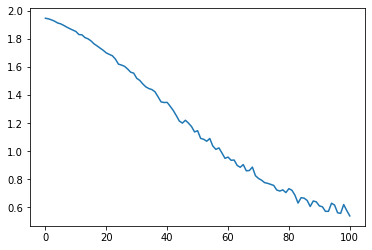

In [46]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in listoflosses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

In [47]:
import seaborn as sns
acc = [acc for acc in listofaccs] 
acc_indices = [i for i,l in enumerate(acc)] 
plt = sns.lineplot(acc_indices,acc)
plt


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
